#라이브러리 설치 & 데이터 불러오기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dataprep

In [ ]:
# pycaret에 없는 모델 설치
!pip install xgboost
!pip install --upgrade xgboost
!pip install catboost

In [ ]:
!pip install pycaret[full]

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
!pip install pycaret[full]

In [ ]:
# import pycaret
import pycaret

from pycaret.classification import *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN

In [ ]:
#model
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

#import optuna
import optuna
from optuna.samplers import TPESampler

In [ ]:
#import train file
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2022-1 ML/9565_hospital_data/train.csv")

In [ ]:
#import test file
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2022-1 ML/9565_hospital_data/test.csv")

In [ ]:
#NaN값 다 삭제
train_df = train_df.dropna()
train_df = train_df.reset_index(drop = True)

# 미리 필요없다 싶은 행 및 칼럼 드랍 & np.NaN 만들기

In [ ]:
#수치형, 범주형 변수 선택
X_num = train_df[['OC', 'revenue1', 'salescost1', 'sga1', 'profit1', 'liquidAsset1', 'nonCAsset1', 'debt1', 'netAsset1', 'revenue2', 'salescost2', 'sga2', 'profit2', 'liquidAsset2', 'nonCAsset2', 'debt2', 'netAsset2',
                  'liquidLiabilities1', 'liquidLiabilities2', 'NCLiabilities1', 'NCLiabilities2']]
X_cat = train_df[['sido', 'openDate',  'bedCount', 'instkind']]

testX_num = test_df[['OC', 'revenue1', 'salescost1', 'sga1', 'profit1', 'liquidAsset1', 'nonCAsset1', 'debt1', 'netAsset1', 'revenue2', 'salescost2', 'sga2', 'profit2', 'liquidAsset2', 'nonCAsset2', 'debt2', 'netAsset2',
                     'liquidLiabilities1', 'liquidLiabilities2', 'NCLiabilities1', 'NCLiabilities2'
       ]]
testX_cat = test_df[['sido', 'openDate',  'bedCount', 'instkind']]

## 부채 = 유동부채 + 비유동부채

안되어 있는 거 메꾸기

In [ ]:
X_num['debt1'] = X_num['liquidLiabilities1'] + X_num['NCLiabilities1']
X_num['debt2'] = X_num['liquidLiabilities2'] + X_num['NCLiabilities2']
testX_num['debt1'] = testX_num['liquidLiabilities1'] + testX_num['NCLiabilities1']
testX_num['debt2'] = testX_num['liquidLiabilities2'] + testX_num['NCLiabilities2']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

## 총 의료비용 구하기

판매비 관리비 + 의료비용

In [ ]:
#sga1 + salescost1

def new_salescost(df):
  for i in range(len(df)):
    df.loc[i, 'new_salescost1'] =  df.loc[i, 'sga1'] + df.loc[i, 'salescost1']
    df.loc[i, 'new_salescost2'] =  df.loc[i, 'sga2'] + df.loc[i, 'salescost2']

In [ ]:
#실행
new_salescost(X_num)
new_salescost(testX_num)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
#기존 salescost, sga drop

X_num = X_num.drop(['salescost1', 'sga1', 'salescost2', 'sga2'], axis = 1)
testX_num = testX_num.drop(['salescost1', 'sga1', 'salescost2', 'sga2'], axis = 1)

##총자산 구하기

In [ ]:
def totalAsset(df):
  for i in range(len(df)):
    df.loc[i, 'totalAsset1'] =  df.loc[i, 'liquidAsset1'] + df.loc[i, 'nonCAsset1']
    df.loc[i, 'totalAsset2'] =  df.loc[i, 'liquidAsset2'] + df.loc[i, 'nonCAsset2']


In [ ]:
#실행
totalAsset(X_num)
totalAsset(testX_num)

In [ ]:
#기존 유동자산, 비유동자산 drop

X_num = X_num.drop(['liquidAsset1', 'nonCAsset1', 'liquidAsset2', 'nonCAsset2'], axis = 1)
testX_num = testX_num.drop(['liquidAsset1', 'nonCAsset1', 'liquidAsset2', 'nonCAsset2'], axis = 1)

## 자기자본 구하기

totalasset - debt

In [ ]:
testX_num

,OC,revenue1,profit1,debt1,netAsset1,revenue2,profit2,debt2,netAsset2,liquidLiabilities1,liquidLiabilities2,NCLiabilities1,NCLiabilities2,new_salescost1,new_salescost2,totalAsset1,totalAsset2
0,NaN,6.682486e+10,5.036692e+08,6.769090e+10,6.295769e+09,6.360375e+10,5.181821e+08,5.540443e+10,1.608540e+10,5.426088e+10,5.068443e+10,1.343002e+10,4.720000e+09,6.565709e+10,6.261126e+10,7.398666e+10,7.149183e+10
1,NaN,3.495758e+10,4.525557e+08,6.626737e+10,1.470447e+10,3.754253e+10,-4.645265e+09,6.730838e+10,3.789135e+09,4.210945e+10,4.209828e+10,2.415791e+10,2.521009e+10,3.259270e+10,3.868523e+10,8.097183e+10,7.109751e+10
2,NaN,2.326031e+10,-2.148749e+09,2.830632e+10,0.000000e+00,2.468035e+10,-1.667198e+09,2.777589e+10,0.000000e+00,2.830632e+10,2.777589e+10,0.000000e+00,0.000000e+00,2.563006e+10,2.523960e+10,4.210781e+10,4.293012e+10
3,NaN,0.000000e+00,2.789663e+09,2.891880e+10,4.702837e+10,0.000000e+00,2.862794e+09,1.211517e+10,3.914284e+10,2.604193e+10,9.556237e+09,2.876879e+09,2.558931e+09,0.000000e+00,0.000000e+00,7.594717e+10,5.125800e+10
4,NaN,5.037025e+10,3.346675e+09,4.921637e+10,2.268194e+10,4.348996e+10,4.614056e+09,4.395973e+10,2.574488e+10,2.503353e+10,7.535567e+09,2.418283e+10,3.642417e+10,4.855803e+10,4.067810e+10,7.189831e+10,6.970461e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NaN,2.233031e+10,1.692204e+09,1.582736e+10,1.554179e+10,2.239509e+10,1.846078e+09,1.563217e+10,1.384958e+10,1.285973e+10,1.288180e+10,2.967635e+09,2.750371e+09,1.934102e+10,1.890423e+10,3.136915e+10,2.948176e+10
123,NaN,1.833906e+10,5.779144e+07,1.938710e+09,9.554694e+09,1.911503e+10,6.731139e+08,3.176628e+09,8.574502e+09,1.893267e+09,1.376742e+09,4.544296e+07,1.799886e+09,1.760117e+10,1.824717e+10,1.149340e+10,1.175113e+10
124,NaN,1.424266e+10,1.772403e+08,0.000000e+00,0.000000e+00,1.307233e+10,1.351264e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.321340e+10,1.223508e+10,0.000000e+00,0.000000e+00
125,NaN,4.892710e+10,1.417343e+09,3.859089e+10,1.212281e+09,4.758477e+10,1.190396e+09,3.720397e+10,-2.050629e+08,9.342814e+09,8.485918e+09,2.924807e+10,2.871805e+10,4.629297e+10,4.521975e+10,3.980317e+10,3.699891e+10


In [ ]:
X_num['netAsset1'] = X_num['totalAsset1'] - X_num['debt1']
X_num['netAsset2'] = X_num['totalAsset2'] - X_num['debt2']
testX_num['netAsset1'] = testX_num['totalAsset1'] - testX_num['debt1']
testX_num['netAsset2'] = testX_num['totalAsset2'] - testX_num['debt2']

## 다 0인 것은 np.NaN 반환

In [ ]:
#의료수익, 의료비용, 당기순이익 없으면 다 NaN 반환하는 함수 (imputation 할거임)

def nan_si(df):
  for i in range(len(df)):
    if df.loc[i, 'revenue1'] ==0 and df.loc[i, 'new_salescost1'] == 0 and df.loc[i, 'profit1'] == 0:
      df.loc[i, ['revenue1', 'new_salescost1', 'profit1']] = np.NaN
    if df.loc[i, 'revenue2'] ==0 and df.loc[i, 'new_salescost2'] == 0 and df.loc[i, 'profit2'] == 0:
      df.loc[i, ['revenue2', 'new_salescost2', 'profit2']] = np.NaN

In [ ]:
#부채총계, 자기자본, 총자산 없으면 다 NaN 반환하는 함수 (imputation 할거임)

def nan_jm(df):
  for i in range(len(df)):
    if df.loc[i, 'totalAsset1'] ==0 and df.loc[i, 'debt1'] == 0 and df.loc[i, 'netAsset1'] == 0:
      df.loc[i, ['totalAsset1', 'debt1', 'netAsset1',]] = np.NaN
    if df.loc[i, 'totalAsset2'] == 0 and df.loc[i, 'debt2'] == 0 and df.loc[i, 'netAsset2'] == 0:
      df.loc[i, ['totalAsset2', 'debt2', 'netAsset2']] = np.NaN

In [ ]:
#train, test에 실행
nan_si(X_num)
nan_si(testX_num)
nan_jm(X_num)
nan_jm(testX_num)


##OC 변수 0과 1로 변환

In [ ]:
X_num['OC'] = X_num['OC'].replace('open', 1)
X_num['OC'] = X_num['OC'].replace(' close', 0)

# train, test 모아서 새로운 변수 생성

In [ ]:
#train, test 합치기
df = pd.concat([X_num, testX_num], axis = 0)
#index 재정렬
df1 = df.reset_index(drop = True)

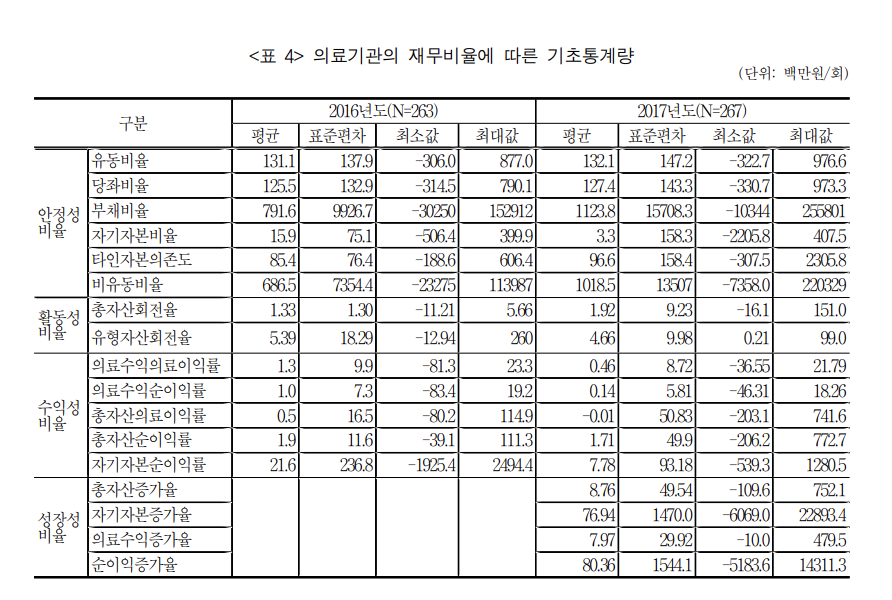

In [ ]:
#새변수- 안정성비율
#df1['유동비율']= (df1['liquidAsset1']/df1['liquidLiabilities1']) * 100 #유동자산 / 유동부채 * 100
df1['부채비율']= (df1['debt1']/(df1['netAsset1'])) * 100  #부채/ 자기자본  * 100
#df1['자기자본비율']= df1['netAsset1']/(df1['totalAsset1']) * 100    #자기자본 / 총자산 * 100
#df1['비유동비율']= (df1['nonCAsset1']/(df1['netAsset1'])) * 100 #비유동자산/ 자기자본 * 100
#새변수- 활동성비율
df1['총자산회전율']= df1['revenue1'] /(df1['totalAsset1']) #의료수익/총자산
#새변수- 수익성비율
df1['의료수익의료이익률']= ((df1['revenue1']-df1['new_salescost1'])/df1['revenue1']) * 100 #의료이익(의료수익-의료비용) / 의료수익 * 100
df1['의료수익순이익률']= (df1['profit1']/df1['revenue1']) * 100 #당기순이익/의료수익 * 100
df1['총자산의료이익률']= ((df1['revenue1']-df1['new_salescost1'])/((df1['totalAsset1']))) * 100 #의료이익/총자산 * 100
df1['총자산의료수익률']= (df1['profit1'] / (df1['totalAsset1'])) * 100 #당기순이익/총자산 * 100
#df1['자기자본순이익률']=(df1['profit1']/df1['netAsset1']) * 100 #당기순이익/자기자본 * 100 
#새변수- 성장성비율
df1['총자산증가율']= (((df1['totalAsset1'])-(df1['totalAsset2']))/(df1['totalAsset2'])) * 100 #(당기총자산 - 전기총자산 ) / 전기총자산 * 100 
#df1['자기자본증가율']= (df1['netAsset1']-df1['netAsset2'])/df1['netAsset2'] * 100 #(당기자기자본 - 전기자기자본) / 전기자기자본 * 100
df1['의료수익증가율']= ((df1['revenue1']-df1['revenue2'])/df1['revenue2']) * 100 #(당기의료수익 - 전기의료수익) / 전기의료수익 * 100
df1['순이익증가율']= ((df1['profit1']-df1['profit2'])/df1['profit2']) * 100 #(당기순이익 - 전기순이익) / 전기순이익 * 100 


In [ ]:
#inf인거 0, -inf, 인 거 -100으로 만들어주기
df1 = df1.replace(np.inf, 0)
df1 = df1.replace(-np.inf, -100)

In [ ]:
#닫아야 하는 아이들의 모양을 살펴보자. 
df1[df1['OC'] == 0]

,OC,revenue1,profit1,debt1,netAsset1,revenue2,profit2,debt2,netAsset2,liquidLiabilities1,liquidLiabilities2,NCLiabilities1,NCLiabilities2,new_salescost1,new_salescost2,totalAsset1,totalAsset2,부채비율,총자산회전율,의료수익의료이익률,의료수익순이익률,총자산의료이익률,총자산의료수익률,총자산증가율,의료수익증가율,순이익증가율
101,0.0,2.179021e+09,1.844022e+08,1.249684e+10,7.720191e+09,NaN,NaN,NaN,NaN,5.800804e+09,0.000000e+00,6.696035e+09,0.000000e+00,1.819774e+09,NaN,2.021703e+10,NaN,161.872137,0.107781,16.486629,8.462620,1.776953,0.912113,NaN,NaN,NaN
131,0.0,8.845472e+09,1.552612e+09,6.655088e+09,5.699519e+09,8.826799e+09,-2.665958e+09,1.495243e+10,2.500740e+08,2.733884e+09,1.001811e+10,3.921205e+09,4.934328e+09,7.958490e+09,8.466494e+09,1.235461e+10,1.520251e+10,116.765786,0.715965,10.027524,17.552622,7.179361,12.567071,-18.733094,0.211552,-158.238433
148,0.0,3.581089e+09,5.236575e+06,5.121516e+09,4.226966e+09,2.761941e+09,4.385311e+06,5.381396e+09,4.216729e+09,1.692526e+09,2.031396e+09,3.428991e+09,3.350000e+09,3.358945e+09,2.633511e+09,9.348482e+09,9.598125e+09,121.162948,0.383066,6.203250,0.146229,2.376256,0.056015,-2.600954,29.658430,19.411713
167,0.0,1.683125e+10,1.955183e+09,9.194518e+09,2.267631e+10,1.403887e+10,3.464353e+08,1.430577e+10,1.606544e+10,1.642488e+09,1.682877e+09,7.552030e+09,1.262290e+10,1.471819e+10,1.306250e+10,3.187083e+10,3.037121e+10,40.546797,0.528108,12.554379,11.616383,6.630072,6.134709,4.937633,19.890315,464.371649
201,0.0,9.125255e+08,-1.804672e+08,1.006269e+09,1.499370e+09,9.425389e+08,-7.516312e+07,1.035994e+09,1.679837e+09,2.874159e+08,3.075474e+08,7.188532e+08,7.284463e+08,1.070411e+09,1.007915e+09,2.505639e+09,2.715831e+09,67.112810,0.364189,-17.302014,-19.776679,-6.301199,-7.202445,-7.739504,-3.184316,140.100794
243,0.0,7.162790e+09,6.637040e+08,NaN,NaN,5.061720e+09,-1.357443e+09,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.263256e+09,5.267020e+09,NaN,NaN,NaN,NaN,12.558433,9.265997,NaN,NaN,NaN,41.509024,-148.893693
270,0.0,2.375764e+09,-2.483311e+09,1.215538e+10,4.433309e+09,NaN,NaN,NaN,NaN,5.555377e+09,0.000000e+00,6.600000e+09,0.000000e+00,4.466998e+09,NaN,1.658869e+10,NaN,274.182976,0.143216,-88.023659,-104.526834,-12.606388,-14.969905,NaN,NaN,NaN


# 범주형 변수 생성

##지역 변수 만들기

In [ ]:
#X_sido 만들어주기
b = pd.concat([X_cat, testX_cat], axis = 0)
b = b.reset_index(drop=True)
X_sido = b[['sido']]

In [ ]:
X_sido['sido'].unique()

array(['choongnam', 'gyeonggi', 'incheon', 'gyeongnam', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong', 'jeju'],
      dtype=object)

In [ ]:
conditionlist = [
    (X_sido['sido'] == 'choongbuk') | (X_sido['sido'] == 'choongnam') | (X_sido['sido'] == 'gangwon') | (X_sido['sido'] == 'gyeonggi'),
    (X_sido['sido'] == 'jeonbuk') | (X_sido['sido'] == 'jeonnam') | (X_sido['sido'] == 'gyeongbuk') | (X_sido['sido'] == 'gyeongnam') | (X_sido['sido'] == 'jeju'),
    (X_sido['sido'] == 'seoul') | (X_sido['sido'] == 'incheon') | (X_sido['sido'] == 'daegu') | (X_sido['sido'] == 'busan')| (X_sido['sido'] == 'ulsan') |
     (X_sido['sido'] == 'daejeon') | (X_sido['sido'] == 'sejong') | (X_sido['sido'] == 'gwangju')]

choicelist = ['joongbu', 'nambu', 'gwangyeok']
X_sido['new_sido'] = np.select(conditionlist, choicelist, default= 'asdf')
X_sido = X_sido.drop(['sido'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#더미변수로 변환
X_sido = pd.get_dummies(X_sido)

# 다 모아주고 Iterative Imputer 및 기타 전처리

In [ ]:
#여태까지 했던 거 다 붙이기

df2 = pd.concat([df1, X_sido], axis = 1)

#인덱스 재정렬
df2 = df2.reset_index(drop=True)

#train set만 뽑기 

train_df = df2[: X_num.shape[0]]
test_df = df2[X_num.shape[0]:]
test_df = test_df.drop(['OC'], axis = 1)

#인덱스 재정렬
test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)


In [ ]:
#open 중에 결측치 있으면 제거
a = train_df[train_df['OC']==1].dropna()
b = train_df[train_df['OC']==0]

train_df = pd.concat([a, b], axis = 0)
train_df = train_df.reset_index(drop = True)

In [ ]:
#부채비율, 순이익증가율 outlier 제거

a= train_df[train_df['부채비율']<-1000].index
b = train_df[train_df['부채비율']>2000].index
print(a)
print(b)
train_df = train_df.drop(a)
train_df = train_df.drop(b)

Int64Index([84, 117, 148, 215], dtype='int64')
Int64Index([2, 11, 21], dtype='int64')


In [ ]:
a = train_df[train_df['순이익증가율']<-1000].index
train_df = train_df.drop(a)
train_df = train_df.reset_index(drop = True)

In [ ]:
#필요한 칼럼들만 뽑기

train_df1 = train_df[['OC',	'revenue1',	'profit1',	'debt1',	'netAsset1', 'new_salescost1', 'totalAsset1', '부채비율',	'총자산회전율',
                     '의료수익의료이익률',	'의료수익순이익률',	'총자산의료이익률',	'총자산의료수익률',	'총자산증가율',	'의료수익증가율',	'순이익증가율']]


test_df1 = test_df[['revenue1',	'profit1',	'debt1',	'netAsset1', 'new_salescost1', 'totalAsset1', '부채비율',	'총자산회전율',
                     '의료수익의료이익률',	'의료수익순이익률',	'총자산의료이익률',	'총자산의료수익률',	'총자산증가율',	'의료수익증가율',	'순이익증가율']]

In [ ]:
# iterative imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(random_state=42)
train_df1 = pd.DataFrame(imputer.fit_transform(train_df1), columns = ['OC',	'revenue1',	'profit1',	'debt1',	'netAsset1', 'new_salescost1', 'totalAsset1', '부채비율',	'총자산회전율',
                    '의료수익의료이익률',	'의료수익순이익률',	'총자산의료이익률',	'총자산의료수익률',	'총자산증가율',	'의료수익증가율', '순이익증가율'])
test_df1 = pd.DataFrame(imputer.fit_transform(test_df1), columns = ['revenue1',	'profit1',	'debt1',	'netAsset1', 'new_salescost1', 'totalAsset1', '부채비율',	'총자산회전율',
                     '의료수익의료이익률',	'의료수익순이익률',	'총자산의료이익률',	'총자산의료수익률',	'총자산증가율',	'의료수익증가율', '순이익증가율'])

In [ ]:
#,	'revenue1',	'profit1',	'debt1',	'netAsset1', 'new_salescost1', 'totalAsset1',
#	'부채비율',	'총자산회전율', '의료수익의료이익률',	'의료수익순이익률',	'총자산의료이익률',	'총자산의료수익률',	'총자산증가율',	'의료수익증가율', '순이익증가율'

# PCA

In [ ]:
#train, test 모아서 PCA
X1 = pd.concat([train_df1, test_df1], axis = 0)
X2 = X1.drop(['OC'], axis = 1)
X = X2.reset_index(drop = True)

,OC,revenue1,profit1,debt1,netAsset1,new_salescost1,totalAsset1,부채비율,총자산회전율,의료수익의료이익률,의료수익순이익률,총자산의료이익률,총자산의료수익률,총자산증가율,의료수익증가율,순이익증가율
0,1.0,4.217530e+09,2.251697e+08,6.828260e+08,2.844460e+09,3.961135e+09,3.527286e+09,24.005469,1.195687,6.079276,5.338899,7.268910,6.383652,4.410580,-1.868801,8.343367
1,1.0,7.250734e+10,9.028303e+08,4.236380e+10,1.385710e+10,7.067740e+10,5.622090e+10,305.719023,1.289687,2.523806,1.245157,3.254919,1.605862,10.869051,8.449217,7.686520
2,1.0,3.358054e+10,-4.622738e+07,1.849938e+10,5.785425e+09,3.295091e+10,2.428481e+10,319.758423,1.382780,1.874978,-0.137661,2.592681,-0.190355,-10.044824,-2.195782,-161.895675
3,1.0,2.255218e+10,8.645304e+08,2.412230e+10,1.441743e+10,2.102329e+10,3.853973e+10,167.313512,0.585167,6.779359,3.833467,3.967057,2.243219,0.024425,5.212700,79.122694
4,1.0,6.435917e+10,4.533181e+08,4.688602e+10,4.463115e+09,6.164055e+10,5.134913e+10,1050.522229,1.253364,4.224140,0.704357,5.294386,0.882816,2.283640,8.173154,-59.951615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NaN,2.233031e+10,1.692204e+09,1.582736e+10,1.554179e+10,1.934102e+10,3.136915e+10,101.837468,0.711856,13.386678,7.578058,9.529381,5.394483,6.401902,-0.289299,-8.335186
123,NaN,1.833906e+10,5.779144e+07,1.938710e+09,9.554694e+09,1.760117e+10,1.149340e+10,20.290653,1.595616,4.023634,0.315128,6.420176,0.502823,-2.193207,-4.059480,-91.414316
124,NaN,1.424266e+10,1.772403e+08,1.479640e+10,7.453123e+09,1.321340e+10,2.224953e+10,266.096166,0.742831,7.226643,1.244432,10.962504,0.383164,6.794763,8.952727,31.166311
125,NaN,4.892710e+10,1.417343e+09,3.859089e+10,1.212281e+09,4.629297e+10,3.980317e+10,3183.329781,1.229226,5.383783,2.896848,6.617887,3.560881,7.579308,2.820913,19.064895


In [ ]:
# 수치형 데이터 표준화하기 - 얘는 train test 합쳐서 해야 하는건가?
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

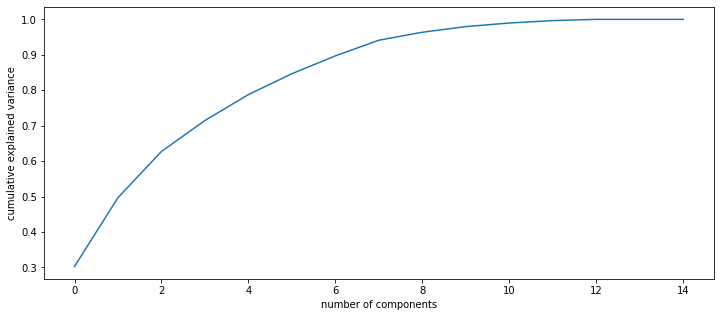

In [ ]:
pca = PCA(random_state = 2022).fit(X)
plt.figure(figsize = (12, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xticks(np.arange(0, 15, step = 2))
plt.ylabel('cumulative explained variance');

In [ ]:
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산 비율':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(15)]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율,기여율,누적기여율
pca1,4.555052e+00,3.028219e-01,0.302822
pca2,2.920947e+00,1.941858e-01,0.497008
pca3,1.959886e+00,1.302941e-01,0.627302
pca4,1.313500e+00,8.732205e-02,0.714624
pca5,1.099388e+00,7.308782e-02,0.787712
pca6,8.865136e-01,5.893582e-02,0.846648
pca7,7.570893e-01,5.033164e-02,0.896979
pca8,6.646934e-01,4.418911e-02,0.941168
pca9,3.377821e-01,2.245590e-02,0.963624
pca10,2.405213e-01,1.598996e-02,0.979614


In [ ]:
#PCA -주성분 7개 시도
pca = PCA(n_components=7, random_state = 2022)
X = pca.fit_transform(X)

X = pd.DataFrame(X, columns = [f"pca_{i+1}" for i in range(7)])

In [ ]:
X

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
0,-0.946017,-0.938460,-0.263323,-0.413973,-0.292311,0.297962,-0.372691
1,3.976938,0.292529,0.346933,0.580295,0.113934,-0.165730,-0.579071
2,0.945583,-0.222529,0.366254,1.103555,-0.650202,0.751018,-0.515946
3,1.207820,0.223592,-0.056945,-0.129951,-0.250795,0.273582,0.425849
4,3.419141,0.415872,0.556396,2.523758,0.184362,-0.792537,-1.045423
...,...,...,...,...,...,...,...
353,1.087881,-0.162904,-0.416703,-0.804842,-0.124255,0.095794,-0.012685
354,-0.119703,-0.664377,0.044576,0.002743,-0.584870,0.832821,-0.421659
355,0.080464,0.136721,-0.129468,0.139870,0.046716,-0.111912,0.125510
356,2.877972,0.280854,0.731271,6.019475,1.291030,-3.802982,-2.350154


In [ ]:
#각 주성분들이 기존 변수들과 어떤 관련성이 있는지 확인
loadings = pca.components_
num_pca = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pca+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X2.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
revenue1,0.446456,0.064177,0.047769,0.060132,-0.030257,0.032054,-0.148849
profit1,0.255689,-0.085599,-0.139535,-0.432198,-0.080931,-0.089246,-0.495700
debt1,0.409541,0.120581,0.047642,0.176110,0.045854,-0.063296,-0.008398
netAsset1,0.360714,0.100752,0.014625,-0.218868,0.003050,0.119806,0.465122
new_salescost1,0.442947,0.068990,0.059630,0.086157,-0.025145,0.038163,-0.113961
totalAsset1,0.441356,0.127172,0.037424,-0.000629,0.030405,0.021174,0.231541
부채비율,0.051926,0.049826,0.081445,0.683565,0.164226,-0.436376,-0.151265
총자산회전율,0.124037,-0.396186,0.057187,0.161443,-0.107073,0.093711,-0.440567
의료수익의료이익률,0.059424,-0.130925,-0.657612,0.164931,0.004090,0.060463,0.104976


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_

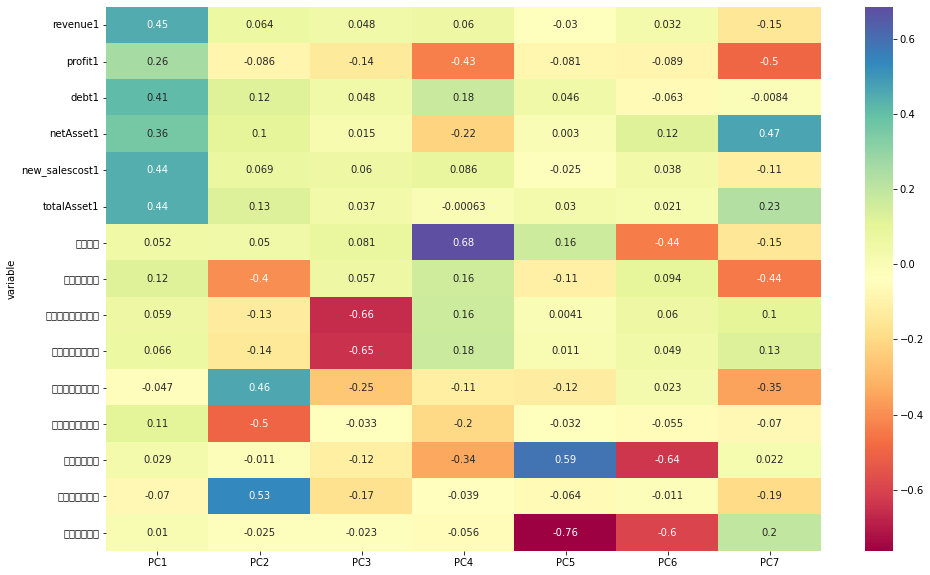

In [ ]:
plt.subplots(figsize=(16,10))
ax = sns.heatmap(loadings_df, annot = True, cmap = 'Spectral')
plt.show()

NameError: ignored

In [ ]:
'''
#bedcount 붙이기
a = pd.concat([train_df[[,'new_bedCount_100이상', 'new_bedCount_30이상', 'new_bedCount_30미만']],
              test_df[['new_bedCount_100이상', 'new_bedCount_30이상', 'new_bedCount_30미만']]], axis = 0)
a = a.reset_index(drop = True)

X = pd.concat([X, a], axis = 1)
'''

#sido 붙이기
a = pd.concat([train_df[['new_sido_gwangyeok', 'new_sido_joongbu', 'new_sido_nambu']],
              test_df[['new_sido_gwangyeok', 'new_sido_joongbu', 'new_sido_nambu']]], axis = 0)
a = a.reset_index(drop = True)

X = pd.concat([X, a], axis = 1)

In [ ]:
X_train = X[:train_df1.shape[0]]
X_train = pd.concat([X_train, train_df['OC']], axis =1 )
            
X_test = X[train_df1.shape[0]:]
X_test = X_test.reset_index(drop = True)

In [ ]:
X_test

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,new_sido_gwangyeok,new_sido_joongbu,new_sido_nambu
0,4.446094,1.555551,0.621233,-1.981747,-0.336457,-0.764416,1.677786,1,0,0
1,3.437917,1.132992,1.130271,-0.332906,0.221924,-0.324423,0.334765,0,0,1
2,0.679930,1.829996,0.694708,-1.030222,-0.280888,0.683855,-1.028191,0,0,1
3,2.466431,-0.005677,2.231170,3.074679,1.548589,-1.256973,-0.898164,1,0,0
4,4.255700,0.081878,0.145520,0.708151,-0.166966,-0.273790,0.064887,0,0,1
5,3.439963,0.043387,0.067853,0.308181,-0.765753,0.310510,0.170312,0,1,0
6,5.451403,0.909287,-0.111660,-0.281453,-0.163666,0.597450,-0.472068,0,1,0
7,1.521677,-0.168467,-0.451672,-0.656239,-0.377897,-0.395465,0.777913,0,0,1
8,-0.156103,-0.344344,1.232711,0.400154,0.084146,-0.357029,0.044677,0,0,1
9,4.330958,0.912925,-0.052941,-1.339799,-0.804972,0.046818,1.091103,0,1,0


In [ ]:
X_train[X_train["OC"] == 0]

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,new_sido_gwangyeok,new_sido_joongbu,new_sido_nambu,OC
228,-0.603651,-0.209741,0.460812,0.071213,-0.075270,0.004400,-0.263170,0,1,0,0.0
229,-0.899564,-0.876496,-0.104034,0.408795,-0.083637,-0.082655,0.042831,0,0,1,0.0
230,-0.540352,-0.008960,0.921528,0.373098,-0.089723,-0.029521,-0.449395,0,0,1,0.0
231,-0.072353,-1.461992,-0.478869,0.707635,-1.127348,0.244413,0.241756,1,0,0,0.0
232,-1.021814,0.052765,0.353960,0.120598,-0.384535,0.324962,-0.381261,0,0,1,0.0
233,1.051841,-0.842423,0.168431,1.279828,-0.235318,-0.085555,-0.555984,0,0,1,0.0
234,-1.028379,1.578071,-0.515621,0.824749,0.022708,-0.129951,-0.002476,0,1,0,0.0
235,1.185901,-0.761325,-0.026449,0.820794,-0.036731,0.020035,-0.049391,0,0,1,0.0
236,-1.717993,1.147176,0.163258,-0.250721,-0.454595,0.520589,-0.918375,1,0,0,0.0
237,-0.282518,-0.495136,0.248396,0.305721,0.011007,-0.072008,-0.084366,0,1,0,0.0


# ADASYN

<AxesSubplot:xlabel='OC', ylabel='count'>

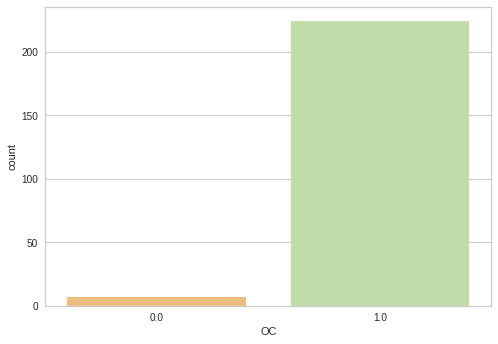

In [ ]:
#ADASYN 전
sns.countplot(x="OC", data=X_train, palette='Spectral') #차이가 너무 크다


In [ ]:
# X, Y분리
X_OC = X_train.drop(['OC'], axis = 1)
Y_OC = X_train[['OC']]

In [ ]:
adasyn = ADASYN(random_state=42)
X_OC, Y_OC = adasyn.fit_resample(X_OC, Y_OC)

In [ ]:
'''
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_OC,Y_OC = smote_tomek.fit_resample(X_OC, Y_OC)
'''

'\nfrom imblearn.combine import SMOTETomek\nsmote_tomek = SMOTETomek(random_state=42)\nX_OC,Y_OC = smote_tomek.fit_resample(X_OC, Y_OC)\n'

In [ ]:
#X, Y 재결합
X_train = pd.concat([X_OC, Y_OC], axis = 1)

<AxesSubplot:xlabel='OC', ylabel='count'>

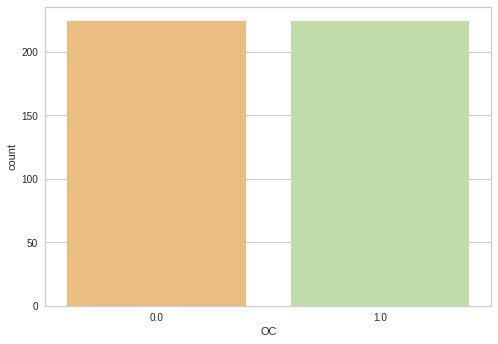

In [ ]:
#ADASYN 후
sns.countplot(x="OC", data=X_train, palette='Spectral') #늘어났다.


#Pycaret

In [ ]:
model = setup(
    data = X_train,
    target = "OC",
    fold = 5
)

,Description,Value
0,session_id,3633
1,Target,OC
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(448, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
top4_model = compare_models(
               round=4,
               sort="Accuracy",
               n_select = 4 )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9681,0.9720,0.9625,0.9752,0.9683,0.9362,0.9372,0.538
gbc,Gradient Boosting Classifier,0.9554,0.9890,0.9498,0.9640,0.9562,0.9107,0.9120,0.100
lightgbm,Light Gradient Boosting Machine,0.9521,0.9916,0.9498,0.9575,0.9529,0.9042,0.9056,0.144
rf,Random Forest Classifier,0.9490,0.9887,0.9435,0.9573,0.9498,0.8979,0.8992,0.546
catboost,CatBoost Classifier,0.9489,0.9910,0.9435,0.9575,0.9495,0.8978,0.8996,2.944
ada,Ada Boost Classifier,0.9458,0.9737,0.9058,0.9869,0.9441,0.8917,0.8955,0.102
xgboost,Extreme Gradient Boosting,0.9456,0.9893,0.9433,0.9497,0.9462,0.8912,0.8919,1.074
dt,Decision Tree Classifier,0.9329,0.9333,0.9121,0.9542,0.9324,0.8658,0.8672,0.016
svm,SVM - Linear Kernel,0.9074,0.0000,0.8871,0.9316,0.9069,0.8149,0.8189,0.014
knn,K Neighbors Classifier,0.9041,0.9635,0.8429,0.9645,0.8991,0.8087,0.8161,0.134


In [ ]:
blend5_stack = stack_models(estimator_list=top5_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9048,0.9859,0.9375,0.8824,0.9091,0.8093,0.8109
1,0.9841,0.9970,1.0000,0.9697,0.9846,0.9682,0.9687
2,0.9841,0.9879,1.0000,0.9697,0.9846,0.9682,0.9687
3,0.9677,0.9979,0.9677,0.9677,0.9677,0.9355,0.9355
4,0.9677,0.9906,0.9375,1.0000,0.9677,0.9356,0.9375
Mean,0.9617,0.9919,0.9685,0.9579,0.9628,0.9234,0.9243
SD,0.0294,0.0048,0.0280,0.0396,0.0279,0.0589,0.0585


In [ ]:
final_model = finalize_model(blend5_stack)

In [ ]:
prediction = predict_model(final_model, data = X_test) 

In [ ]:
prediction

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,new_sido_gwangyeok,new_sido_joongbu,new_sido_nambu,Label,Score
0,4.446094,1.555551,0.621233,-1.981747,-0.336457,-0.764416,1.677786,1,0,0,1.0,0.9966
1,3.437917,1.132992,1.130271,-0.332906,0.221924,-0.324423,0.334765,0,0,1,1.0,0.9890
2,0.679930,1.829996,0.694708,-1.030222,-0.280888,0.683855,-1.028191,0,0,1,1.0,0.9303
3,2.466431,-0.005677,2.231170,3.074679,1.548589,-1.256973,-0.898164,1,0,0,1.0,0.9470
4,4.255700,0.081878,0.145520,0.708151,-0.166966,-0.273790,0.064887,0,0,1,1.0,0.9880
...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.143703,-0.754401,-0.052574,0.818405,-0.037212,0.010792,-0.050885,0,0,1,1.0,0.9862
123,-0.138845,-0.435206,-1.050338,-0.501181,-0.181895,0.745339,-0.414492,0,1,0,1.0,0.9851
124,0.088017,-0.052671,0.111716,-0.092784,-0.047147,0.243929,0.217857,0,1,0,1.0,0.9423
125,2.855281,1.315487,0.886738,-4.331372,-0.446567,-3.570845,5.455398,0,0,1,1.0,0.9986


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2022-1 ML/9565_hospital_data/submission_sample.csv')
submission['OC'] = prediction['Label']
submission

,inst_id,OC
0,2,1.0
1,5,1.0
2,6,1.0
3,8,1.0
4,10,1.0
...,...,...
122,424,1.0
123,425,1.0
124,429,1.0
125,430,1.0


In [ ]:
submission.to_csv("submission2.27-1.csv", index=False)

In [ ]:
evaluate_model(blend5_stack)

<Figure size 576x396 with 0 Axes>

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…